## Analysis of I24 Dataset

The primary goal of this project is to replicate the results and findings of a specific research paper that investigates the impact of neighboring sensor measurements and Time-to-Detection Accuracy (TTDA) on accident detection accessible under the following [*link*](https://www.sciencedirect.com/science/article/pii/S0957417423033158?via%3Dihub). <br><br>
In particular, this notebook contains the analysis and results for the I-24 intersection. Below you may find all the steps taken by us in order to replicate the paper. 

In [1]:
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

In [2]:
import pandas as pd
from utils.data_preprocessor import DataPreprocessor
from utils.ML_classifier import MLClassifier

The dataset we are loading is a record of signals gathered from various sensors scattered around the intersection **I24**. We are investigating variables *(measured in 30 second intervals)* such as: <br>
 - **occupancy**: mean % of occupancy
 - **speed**: mean speed at the sensor location where *(i+x)* indicates other sensors, down- or upstream, relative to i+0
 - **volume**: count of all vehicles passing

In [3]:
# Load data
I24_data = pd.read_csv('../data/input/I24_data.csv', low_memory=False)
I24_data

,incident at sensor (i),road,mile,type,date,incident_time,incident_hour,data_time,weather,light,...,occupancy (i+2),speed (i+3),volume (i+3),occupancy (i+3),speed (i+4),volume (i+4),occupancy (i+4),speed (i+5),volume (i+5),occupancy (i+5)
0,1,00I24E,177.8,Suspected Minor Injury,2021-03-05,15:20,15,15:05:00,--,Daylight,...,3.897500e+02,31.75,2562.0,4065916.00,NaN,NaN,NaN,NaN,NaN,NaN
1,1,00I24E,177.8,Suspected Minor Injury,2021-03-05,15:20,15,15:05:30,--,Daylight,...,1.155292e+05,31.75,6464.0,4550758.75,NaN,NaN,NaN,NaN,NaN,NaN
2,1,00I24E,177.8,Suspected Minor Injury,2021-03-05,15:20,15,15:06:00,--,Daylight,...,3.303106e+06,25.00,4751.0,2848578.00,NaN,NaN,NaN,NaN,NaN,NaN
3,1,00I24E,177.8,Suspected Minor Injury,2021-03-05,15:20,15,15:06:30,--,Daylight,...,2.780782e+06,24.75,4264.0,6395809.75,NaN,NaN,NaN,NaN,NaN,NaN
4,1,00I24E,177.8,Suspected Minor Injury,2021-03-05,15:20,15,15:07:00,--,Daylight,...,1.896250e+03,22.00,4743.0,1593311.75,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302741,0,00I24E,182.4,NaN,2021-04-16,18:11,18,18:24:30,--,Daylight,...,9.333333e+00,NaN,NaN,NaN,64.000000,27.0,4.666667,NaN,NaN,NaN
302742,0,00I24E,182.4,NaN,2021-04-16,18:11,18,18:25:00,--,Daylight,...,1.200000e+01,NaN,NaN,NaN,61.333333,32.0,10.000000,NaN,NaN,NaN
302743,0,00I24E,182.4,NaN,2021-04-16,18:11,18,18:25:30,--,Daylight,...,1.066667e+01,NaN,NaN,NaN,63.666667,25.0,8.666667,NaN,NaN,NaN
302744,0,00I24E,182.4,NaN,2021-04-16,18:11,18,18:26:00,--,Daylight,...,7.666667e+00,NaN,NaN,NaN,62.333333,25.0,7.333333,NaN,NaN,NaN


### Variables Type Conversion

We begin by organizing the data available through the courtesy of authors [here](https://zenodo.org/records/7964288?fbclid=IwAR2LaBH597NvJrA9z8qyvHb0aFHbTnqvm_sM-UHq65XLcJfoKq2LuMClrD8). The initial step consists in ensuring a proper variable type in all scenarios. This in turn enables the code further along to work properly when reproduced.

In [4]:
# Convert 'date' type
I24_data['date'] = pd.to_datetime(I24_data['date'])

In [5]:
# Convert 'incident_time' and 'data_time' to datetime
I24_data['incident_time'] = pd.to_datetime(I24_data['date'].dt.strftime('%Y-%m-%d') + ' ' + I24_data['incident_time'], format='%Y-%m-%d %H:%M')

# Adjust `data_time` for potential rollover to the next or previous day
def adjust_observation_time(row):
    data_time = pd.to_datetime(row['date'].strftime('%Y-%m-%d') + ' ' + row['data_time'], format='%Y-%m-%d %H:%M:%S')
    if data_time < row['incident_time'] - pd.Timedelta(hours=12):
        data_time += pd.Timedelta(days=1)
    elif data_time > row['incident_time'] + pd.Timedelta(hours=12):
        data_time -= pd.Timedelta(days=1)
    return data_time

I24_data['data_time'] = I24_data.apply(adjust_observation_time, axis=1)

### Filtering the Dataset

The first crucial step in accessing the data we want to analyze is proper filtering. We are following the authors and filtering data as per the steps summarized in section *3.8. Final dataset*, which consists in removing unnecessary variables and leaving only measurements from at least 4 minutes before and up to 7 minutes after an accident has occured.

In [6]:
# Calculate the time difference in minutes
I24_data['time_diff'] = (I24_data['data_time'] - I24_data['incident_time']).dt.total_seconds() / 60

# Filter data for observations from 4 min before up to 7 min after an accident/non-accident
filtered_I24_data = I24_data[(I24_data['time_diff'] >= -4) & (I24_data['time_diff'] <= 7)]
filtered_I24_data

,incident at sensor (i),road,mile,type,date,incident_time,incident_hour,data_time,weather,light,...,speed (i+3),volume (i+3),occupancy (i+3),speed (i+4),volume (i+4),occupancy (i+4),speed (i+5),volume (i+5),occupancy (i+5),time_diff
22,1,00I24E,177.8,Suspected Minor Injury,2021-03-05,2021-03-05 15:20:00,15,2021-03-05 15:16:00,--,Daylight,...,17.25,5586.0,8585709.75,NaN,NaN,NaN,NaN,NaN,NaN,-4.0
23,1,00I24E,177.8,Suspected Minor Injury,2021-03-05,2021-03-05 15:20:00,15,2021-03-05 15:16:30,--,Daylight,...,14.25,1355.0,3716285.25,NaN,NaN,NaN,NaN,NaN,NaN,-3.5
24,1,00I24E,177.8,Suspected Minor Injury,2021-03-05,2021-03-05 15:20:00,15,2021-03-05 15:17:00,--,Daylight,...,24.50,5466.0,2360606.25,NaN,NaN,NaN,NaN,NaN,NaN,-3.0
25,1,00I24E,177.8,Suspected Minor Injury,2021-03-05,2021-03-05 15:20:00,15,2021-03-05 15:17:30,--,Daylight,...,20.25,2546.0,1080457.00,NaN,NaN,NaN,NaN,NaN,NaN,-2.5
26,1,00I24E,177.8,Suspected Minor Injury,2021-03-05,2021-03-05 15:20:00,15,2021-03-05 15:18:00,--,Daylight,...,19.00,3553.0,1636759.00,NaN,NaN,NaN,NaN,NaN,NaN,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302724,0,00I24E,182.4,NaN,2021-04-16,2021-04-16 18:11:00,18,2021-04-16 18:16:00,--,Daylight,...,NaN,NaN,NaN,53.333333,42.0,16.333333,NaN,NaN,NaN,5.0
302725,0,00I24E,182.4,NaN,2021-04-16,2021-04-16 18:11:00,18,2021-04-16 18:16:30,--,Daylight,...,NaN,NaN,NaN,57.333333,32.0,10.666667,NaN,NaN,NaN,5.5
302726,0,00I24E,182.4,NaN,2021-04-16,2021-04-16 18:11:00,18,2021-04-16 18:17:00,--,Daylight,...,NaN,NaN,NaN,52.333333,34.0,12.000000,NaN,NaN,NaN,6.0
302727,0,00I24E,182.4,NaN,2021-04-16,2021-04-16 18:11:00,18,2021-04-16 18:17:30,--,Daylight,...,NaN,NaN,NaN,51.666667,32.0,9.000000,NaN,NaN,NaN,6.5


In [7]:
# Delete unnecessary variables 
filtered_I24_data = filtered_I24_data.drop(columns=['road', 'mile', 'type', 'date', 'incident_time', 'incident_hour', 'data_time'])
filtered_I24_data

,incident at sensor (i),weather,light,speed (i-5),volume (i-5),occupancy (i-5),speed (i-4),volume (i-4),occupancy (i-4),speed (i-3),...,speed (i+3),volume (i+3),occupancy (i+3),speed (i+4),volume (i+4),occupancy (i+4),speed (i+5),volume (i+5),occupancy (i+5),time_diff
22,1,--,Daylight,68.500000,49.0,33.500000,71.000000,55.0,53.000000,62.000000,...,17.25,5586.0,8585709.75,NaN,NaN,NaN,NaN,NaN,NaN,-4.0
23,1,--,Daylight,68.500000,67.0,27.000000,71.500000,513.0,959.000000,62.500000,...,14.25,1355.0,3716285.25,NaN,NaN,NaN,NaN,NaN,NaN,-3.5
24,1,--,Daylight,67.000000,67.0,36.500000,70.000000,36.0,42.500000,59.500000,...,24.50,5466.0,2360606.25,NaN,NaN,NaN,NaN,NaN,NaN,-3.0
25,1,--,Daylight,69.500000,1314.0,54.000000,70.000000,20.0,5.000000,NaN,...,20.25,2546.0,1080457.00,NaN,NaN,NaN,NaN,NaN,NaN,-2.5
26,1,--,Daylight,67.500000,1119.0,656.000000,70.500000,311.0,607.000000,37.500000,...,19.00,3553.0,1636759.00,NaN,NaN,NaN,NaN,NaN,NaN,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302724,0,--,Daylight,58.000000,28.0,4.142857,59.666667,44.0,9.333333,65.000000,...,NaN,NaN,NaN,53.333333,42.0,16.333333,NaN,NaN,NaN,5.0
302725,0,--,Daylight,58.333333,36.0,8.571429,60.333333,53.0,11.333333,64.000000,...,NaN,NaN,NaN,57.333333,32.0,10.666667,NaN,NaN,NaN,5.5
302726,0,--,Daylight,59.000000,39.0,8.857143,59.000000,33.0,7.333333,65.166667,...,NaN,NaN,NaN,52.333333,34.0,12.000000,NaN,NaN,NaN,6.0
302727,0,--,Daylight,57.500000,45.0,6.000000,60.833333,26.0,4.833333,62.800000,...,NaN,NaN,NaN,51.666667,32.0,9.000000,NaN,NaN,NaN,6.5


In [8]:
# Adjust variables names
filtered_I24_data.rename(columns={'speed (i)': 'speed (i+0)'}, inplace=True)
filtered_I24_data.rename(columns={'volume (i)': 'volume (i+0)'}, inplace=True)
filtered_I24_data.rename(columns={'occupancy (i)': 'occupancy (i+0)'}, inplace=True)

### Handling Missing Values

Missing data quickly became our no. 1 issue, as the description on how to handle such observations within the article is very vague. This is also where we want to put the most emphasis on how the research in question did not provide enough resources to be ***fully reproducible***. As can be seen from the below list, the amount of missing observations is alarming and thus prevents us from building reliable machine learning models. Simply omitting the missing values is also out of the question, as upon further inspection, the missing observations are distributed quite randomly. Our attempts at alleviating this issue for the I24 intersection revolve around filling the remaining missing observations with the mean. <br>
<br> While far from perfect, we see merit in this solution, as it should enable us to gain at least a general outline of the relation between variables, as opposed to skewed and unreliable outputs caused by a significant fraction of the data missing. We present this solution in form of a reproducible code, however it would be valuable to explore methods utilized by the authors of the article, as in the long run, this is not sufficient to arrive at the same conclusions.

In [9]:
print(" \nCount total NaN at each column in a DataFrame : \n\n", filtered_I24_data.isnull().sum()) 

 
Count total NaN at each column in a DataFrame : 

 incident at sensor (i)        0
weather                       0
light                         0
speed (i-5)               20049
volume (i-5)              18137
occupancy (i-5)           18137
speed (i-4)               20535
volume (i-4)              18355
occupancy (i-4)           18355
speed (i-3)               19185
volume (i-3)              16331
occupancy (i-3)           16331
speed (i-2)               15103
volume (i-2)              12111
occupancy (i-2)           12111
speed (i-1)               17387
volume (i-1)              14605
occupancy (i-1)           14605
speed (i+0)                9069
volume (i+0)               7332
occupancy (i+0)            7332
speed (i+1)               13634
volume (i+1)              11504
occupancy (i+1)           11504
speed (i+2)                9417
volume (i+2)               7608
occupancy (i+2)            7608
speed (i+3)               10894
volume (i+3)               8882
occupancy (i+3)    

In the below snippets we deploy the **preprocessor**, available separately as *data_preprocessor.py* which ensures consistency and replicability of our report.

In [10]:
# Data Preprocessing
preprocessor = DataPreprocessor(filtered_I24_data)

In [11]:
preprocessor.replace_missings()
preprocessed_I24_data = preprocessor.get_preprocessed_data()
preprocessed_I24_data

,incident at sensor (i),weather,light,speed (i-5),volume (i-5),occupancy (i-5),speed (i-4),volume (i-4),occupancy (i-4),speed (i-3),...,speed (i+3),volume (i+3),occupancy (i+3),speed (i+4),volume (i+4),occupancy (i+4),speed (i+5),volume (i+5),occupancy (i+5),time_diff
22,1,--,Daylight,68.500000,49.0,33.500000,71.000000,55.0,53.000000,62.000000,...,17.25,5586.0,8585709.75,62.000000,14.0,7.000000,59.666667,14.0,7.833333,-4.0
23,1,--,Daylight,68.500000,67.0,27.000000,71.500000,513.0,959.000000,62.500000,...,14.25,1355.0,3716285.25,62.000000,14.0,7.000000,59.666667,14.0,7.833333,-3.5
24,1,--,Daylight,67.000000,67.0,36.500000,70.000000,36.0,42.500000,59.500000,...,24.50,5466.0,2360606.25,62.000000,14.0,7.000000,59.666667,14.0,7.833333,-3.0
25,1,--,Daylight,69.500000,1314.0,54.000000,70.000000,20.0,5.000000,62.333333,...,20.25,2546.0,1080457.00,62.000000,14.0,7.000000,59.666667,14.0,7.833333,-2.5
26,1,--,Daylight,67.500000,1119.0,656.000000,70.500000,311.0,607.000000,37.500000,...,19.00,3553.0,1636759.00,62.000000,14.0,7.000000,59.666667,14.0,7.833333,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302724,0,--,Daylight,58.000000,28.0,4.142857,59.666667,44.0,9.333333,65.000000,...,61.00,15.0,8.00,53.333333,42.0,16.333333,59.666667,14.0,7.833333,5.0
302725,0,--,Daylight,58.333333,36.0,8.571429,60.333333,53.0,11.333333,64.000000,...,61.00,15.0,8.00,57.333333,32.0,10.666667,59.666667,14.0,7.833333,5.5
302726,0,--,Daylight,59.000000,39.0,8.857143,59.000000,33.0,7.333333,65.166667,...,61.00,15.0,8.00,52.333333,34.0,12.000000,59.666667,14.0,7.833333,6.0
302727,0,--,Daylight,57.500000,45.0,6.000000,60.833333,26.0,4.833333,62.800000,...,61.00,15.0,8.00,51.666667,32.0,9.000000,59.666667,14.0,7.833333,6.5


### One-Hot Encoding

We are further inspired by the original authors and as a final step in data preparation we one-hot encode our variables, once again using the **preprocessor**.

In [12]:
preprocessor.one_hot_encode()
preprocessed_I24_data = preprocessor.get_preprocessed_data()
preprocessed_I24_data

,incident at sensor (i),speed (i-5),volume (i-5),occupancy (i-5),speed (i-4),volume (i-4),occupancy (i-4),speed (i-3),volume (i-3),occupancy (i-3),...,occupancy (i+4),speed (i+5),volume (i+5),occupancy (i+5),time_diff,weather_Rain,weather_Snow,light_Dawn,light_Daylight,light_Dusk
22,1,68.500000,49.0,33.500000,71.000000,55.0,53.000000,62.000000,45.0,88.500000,...,7.000000,59.666667,14.0,7.833333,-4.0,False,False,False,True,False
23,1,68.500000,67.0,27.000000,71.500000,513.0,959.000000,62.500000,511.0,1010.500000,...,7.000000,59.666667,14.0,7.833333,-3.5,False,False,False,True,False
24,1,67.000000,67.0,36.500000,70.000000,36.0,42.500000,59.500000,611.0,1360.500000,...,7.000000,59.666667,14.0,7.833333,-3.0,False,False,False,True,False
25,1,69.500000,1314.0,54.000000,70.000000,20.0,5.000000,62.333333,0.0,30.000000,...,7.000000,59.666667,14.0,7.833333,-2.5,False,False,False,True,False
26,1,67.500000,1119.0,656.000000,70.500000,311.0,607.000000,37.500000,39.0,1209.500000,...,7.000000,59.666667,14.0,7.833333,-2.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302724,0,58.000000,28.0,4.142857,59.666667,44.0,9.333333,65.000000,38.0,7.833333,...,16.333333,59.666667,14.0,7.833333,5.0,False,False,False,True,False
302725,0,58.333333,36.0,8.571429,60.333333,53.0,11.333333,64.000000,35.0,6.666667,...,10.666667,59.666667,14.0,7.833333,5.5,False,False,False,True,False
302726,0,59.000000,39.0,8.857143,59.000000,33.0,7.333333,65.166667,20.0,4.333333,...,12.000000,59.666667,14.0,7.833333,6.0,False,False,False,True,False
302727,0,57.500000,45.0,6.000000,60.833333,26.0,4.833333,62.800000,27.0,10.166667,...,9.000000,59.666667,14.0,7.833333,6.5,False,False,False,True,False


In [ ]:
# Save preprocessed data
#preprocessed_I24_data.to_csv('../data/preprocessed_I24_data.csv', index=False)

### Model Training

Once the data processing is finished we build our classification machine learning models basing on the information provided by the authors in section *4. Methods*. For this purpose *ML_classifier.py* is deployed, once again ensuring consistency across all our outputs. Please refer to the article, as well as our *README.md* file for details regarding the parameter grids scanned and optimized by the algorithm. We use the following machine learning models for the analysis:
- Logistic Regression
- Random Forest
- XGBoost 

Furthermore, according to section *4.3. Detection evaluation*, we evaluate the models based on the following metrics:
- Detection Rate (DR)
- False Alarm Rate (FAR)
- AUC-ROC
- AUC-PR

In [13]:
classifier = MLClassifier(data=preprocessed_I24_data, target='incident at sensor (i)', output_dir='output')
classifier.train_models()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/natalia.roszczypala/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters for Logistic Regression: {'clf__C': 100}
AUC-ROC for Logistic Regression: 0.5230
-----
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for Random Forest: {'clf__n_estimators': 1000}
AUC-ROC for Random Forest: 0.9953
-----
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for XGBoost: {'clf__learning_rate': 0.01, 'clf__n_estimators': 1000}
AUC-ROC for XGBoost: 0.9771
-----


From the above we can conclude that the **Random Forest** model was optimized with a different hyperparameter than in the original article. It also appears to be overfitted as the AUC-ROC equals *0,99*. <br> <br>
The opposite can be said for **XGBoost** and **Logistic Regression** models, as we have managed to find the same hyperparameters as indicated in the article, however with AUC-ROC score of the former (*0,97*) possibly indicating overfitting and the latter having non-existent predictability power (AUC-ROC of *0,52*).

### Sensitivity Analysis

The following code enables for the spatiotemporal sensitivity analysis as well as the creation of heatmaps. Please refer to the section *5.1. Spatiotemporal sensitivity analysis* in the article for methodological details on what the deployed code performs.

In [14]:
results = classifier.sensitivity_analysis()

/Users/natalia.roszczypala/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalia.roszczypala/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalia.roszczypala/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalia.roszczypala/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalia.roszczypala/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

In [15]:
# Plot heatmaps
classifier.generate_heatmap(results) 

The generated heatmaps are located in */scripts/output* path (*insights saved in main repo contain heatmapts for I24*). As can be seen based on the following subsections of *5.1. Spatiotemporal sensitivity analysis* we can conclude that for **Logistic Regression** our output is far off, whereas the other models are somewhat comparable, with a few noticeable differences. Please refer to the article and the indicated path for a visual comparison.

In [16]:
# Summary of results
classifier.generate_summary_table(results)

,Setting,Model,DR,FAR,AUC-ROC,AUC-PR
0,Setting 1,Logistic Regression,0.24 (0.33)/0.00,0.22 (0.30)/0.02,0.49 (0.09)/0.48,0.03 (0.08)/0.01
1,Setting 1,Random Forest,0.17 (0.16)/0.11,0.12 (0.08)/0.08,0.55 (0.07)/0.55,0.02 (0.02)/0.01
2,Setting 1,XGBoost,0.25 (0.16)/0.22,0.23 (0.09)/0.23,0.49 (0.09)/0.49,0.01 (0.01)/0.01
3,Setting 2,Logistic Regression,0.18 (0.28)/0.00,0.16 (0.25)/0.02,0.47 (0.08)/0.47,0.02 (0.07)/0.01
4,Setting 2,Random Forest,0.14 (0.15)/0.11,0.10 (0.08)/0.07,0.55 (0.08)/0.55,0.02 (0.02)/0.01
5,Setting 2,XGBoost,0.23 (0.16)/0.22,0.21 (0.09)/0.21,0.50 (0.09)/0.50,0.01 (0.01)/0.01


Lastly, a comparative table of all metrics has been gathered, similarly to *Table 2* in the article. As can be seen, our models are again suffering from the lack of data and are therefore weaker.

### Feature Importance Analysis

Feature importance analysis is suffering the most from the missing variables problem addressed at the beginning of our notebook. As can be seen on the below graph, we are unable to gather any valuable insights from the **Logistic Regression** model. We would like to further emphasize how a lacking description of handling missing observations have impacted the regression and we believe the below is a sufficient proof for this. For a comparison and insights from the best performing classifier within the paper please refer to *5.2. Feature importance analysis*.

/Users/natalia.roszczypala/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SHAP values for Logistic Regression at TTDA 1.5 min under Setting 2


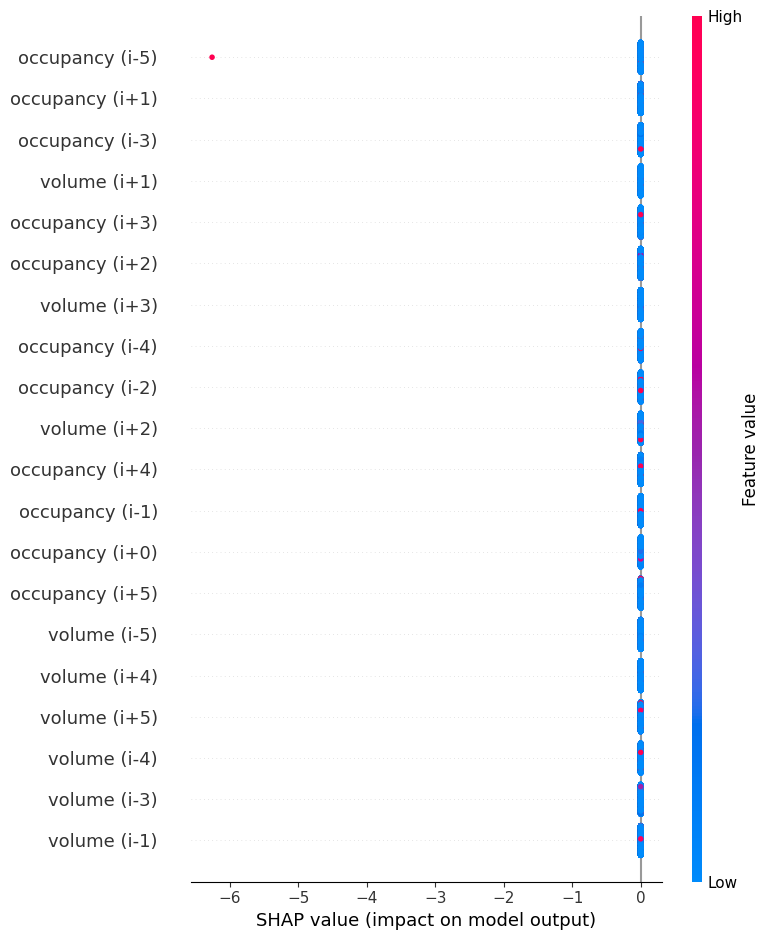

In [17]:
# Plot SHAP values for the best performing model
classifier.plot_shap_values(results) 

### Final remarks

As our final remarks, we would like to again emphasize the importance of reproducible descriptions in all articles, as they are key to ensuring validity of conclusions gathered. In our replica, we have attempted to go step-by-step through the article and confirm the claims set by the authors, however our research was ***inconclusive***, mainly due to missing observations. We believe we presented a fully reproducible solution by utilizing object oriented programming and clearly defining our steps with proper reasoning. Please feel free to utilize this code as per the instructions presented in the *README.md* file.